<a href="https://colab.research.google.com/github/Haque14/Math_629/blob/main/learning_sprint_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# Md Ershadul Haque
```




=== Binary Classification with Moons ===
Model        Acc      ROC_AUC  F1       Train_s  Predict_s  Size_KB
-------------------------------------------------------------------
GradientBoosting 0.9408  0.9841  0.9416  1.602   0.0072   251.0
HistGradientBoosting 0.9368  0.9836  0.9380  0.663   0.0553   693.1
RandomForest 0.9344  0.9799  0.9354  0.965   0.0665   6478.1
AdaBoost     0.9304  0.9823  0.9318  0.753   0.0553   105.5

Best model: GradientBoosting
Artifacts saved:
 - artifacts_moons/summary.tsv
 - artifacts_moons/best_model_GradientBoosting.pkl
 - artifacts_moons/roc_curves.png
 - artifacts_moons/decision_boundary_GradientBoosting.png


{'best_model': 'GradientBoosting',
 'artifacts': {'summary_tsv': 'artifacts_moons/summary.tsv',
  'model_pkl': 'artifacts_moons/best_model_GradientBoosting.pkl',
  'roc_png': 'artifacts_moons/roc_curves.png',
  'decision_boundary_png': 'artifacts_moons/decision_boundary_GradientBoosting.png'}}

<Figure size 640x480 with 0 Axes>

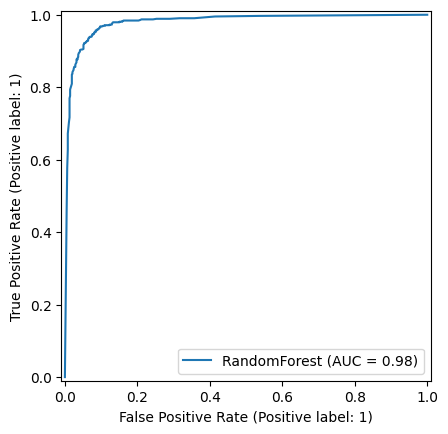

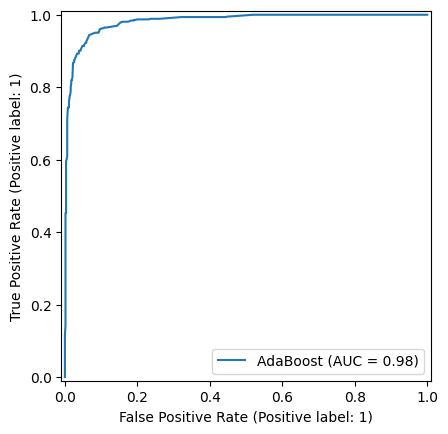

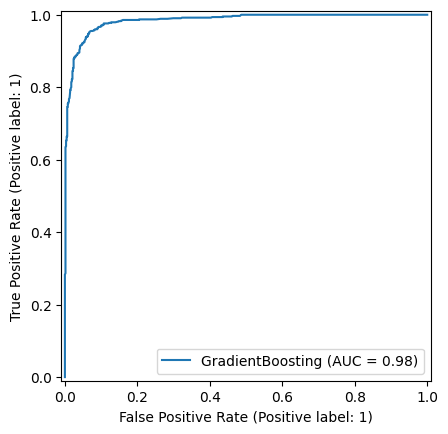

In [ ]:
# 1. Binary Classification with Moons

import os, time, math, pickle
from dataclasses import dataclass
from typing import Dict, Any, List

import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
import matplotlib.pyplot as plt

RNG = 42

@dataclass
class Record:
    Model: str
    Accuracy: float
    ROC_AUC: float
    F1: float
    Train_Time_s: float
    Predict_Time_s: float
    ms_per_sample: float
    Model_Size_KB: float
    TP: int; FP: int; TN: int; FN: int

def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def _model_size_kb(model) -> float:
    try:
        return len(pickle.dumps(model, protocol=pickle.HIGHEST_PROTOCOL)) / 1024.0
    except Exception:
        return float("nan")

def _predict_scores(model, X):
    if hasattr(model, "predict_proba"):
        P = model.predict_proba(X)
        return P[:, 1] if P.ndim == 2 and P.shape[1] == 2 else None
    if hasattr(model, "decision_function"):
        try: return model.decision_function(X)
        except Exception: return None
    return None

def _eval_binary(y_true, y_pred, y_score=None):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    roc = float("nan")
    if y_score is not None:
        try: roc = roc_auc_score(y_true, y_score)
        except Exception: pass
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return acc, roc, f1, tp, fp, tn, fn

def _get_models():
    return {
        "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RNG),
        "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=RNG),
        "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=RNG),
        "HistGradientBoosting": HistGradientBoostingClassifier(max_iter=200, learning_rate=0.05, random_state=RNG),
    }

def _plot_roc_curves(y_true, score_by_model: Dict[str, np.ndarray], outpath: str):
    from sklearn.metrics import RocCurveDisplay
    plt.figure()
    for name, scores in score_by_model.items():
        if scores is None:
            continue
        RocCurveDisplay.from_predictions(y_true, scores, name=name)
    plt.title("ROC Curves – Moons")
    plt.savefig(outpath, bbox_inches="tight"); plt.close()

def _plot_decision_boundary(model, X, y, outpath: str, title: str):
    # grid
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if hasattr(model, "predict_proba"):
        Z = model.predict_proba(grid)[:, 1]
    else:
        Z = model.predict(grid).astype(float)
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, levels=20, alpha=0.8)  # default colormap
    plt.scatter(X[:,0], X[:,1], c=y, s=5)          # default colors
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.savefig(outpath, bbox_inches="tight"); plt.close()

def run_moons(outdir="artifacts_moons"):
    _ensure_dir(outdir)

    # 1) Data
    X, y = make_moons(n_samples=5000, noise=0.25, random_state=0)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.25, random_state=RNG, stratify=y
    )

    # 2) Models
    models = _get_models()

    # 3) Train/Eval
    records: List[Record] = []
    y_scores: Dict[str, np.ndarray] = {}

    for name, m in models.items():
        t0 = time.perf_counter(); m.fit(X_tr, y_tr); train_s = time.perf_counter() - t0
        t1 = time.perf_counter(); y_pred = m.predict(X_te); pred_s = time.perf_counter() - t1
        ms_ps = (pred_s / len(X_te)) * 1000.0
        size_kb = _model_size_kb(m)

        y_score = _predict_scores(m, X_te)
        acc, roc, f1, tp, fp, tn, fn = _eval_binary(y_te, y_pred, y_score)
        y_scores[name] = y_score

        records.append(Record(
            Model=name, Accuracy=acc, ROC_AUC=roc, F1=f1,
            Train_Time_s=train_s, Predict_Time_s=pred_s,
            ms_per_sample=ms_ps, Model_Size_KB=size_kb,
            TP=tp, FP=fp, TN=tn, FN=fn
        ))

    # 4) Pick best (by Accuracy, tie-break ROC AUC)
    records_sorted = sorted(records, key=lambda r: (r.Accuracy, r.ROC_AUC), reverse=True)
    best = records_sorted[0]
    best_model = models[best.Model]

    # 5) Save artifacts
    # Summary TSV
    tsv_path = os.path.join(outdir, "summary.tsv")
    with open(tsv_path, "w", encoding="utf-8") as f:
        f.write("Model\tAccuracy\tROC_AUC\tF1\tTrain_s\tPredict_s\tms_per_sample\tModelSize_KB\tTP\tFP\tTN\tFN\n")
        for r in records_sorted:
            f.write(f"{r.Model}\t{r.Accuracy:.6f}\t{r.ROC_AUC:.6f}\t{r.F1:.6f}\t"
                    f"{r.Train_Time_s:.6f}\t{r.Predict_Time_s:.6f}\t{r.ms_per_sample:.3f}\t"
                    f"{r.Model_Size_KB:.2f}\t{r.TP}\t{r.FP}\t{r.TN}\t{r.FN}\n")

    # Best model pickle
    model_path = os.path.join(outdir, f"best_model_{best.Model}.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)

    # Plots
    roc_path = os.path.join(outdir, "roc_curves.png")
    _plot_roc_curves(y_te, y_scores, roc_path)

    db_path = os.path.join(outdir, f"decision_boundary_{best.Model}.png")
    _plot_decision_boundary(best_model, X_te, y_te, db_path, f"Decision Boundary – {best.Model}")

    # 6) Print concise ranked table
    print("\n=== Binary Classification with Moons ===")
    header = "Model        Acc      ROC_AUC  F1       Train_s  Predict_s  Size_KB"
    print(header); print("-"*len(header))
    for r in records_sorted:
        print(f"{r.Model:<12} {r.Accuracy:0.4f}  {r.ROC_AUC:0.4f}  {r.F1:0.4f}  "
              f"{r.train_Time_s if False else r.Train_Time_s:0.3f}   {r.Predict_Time_s:0.4f}   {r.Model_Size_KB:0.1f}")

    print(f"\nBest model: {best.Model}")
    print("Artifacts saved:")
    print(f" - {tsv_path}")
    print(f" - {model_path}")
    print(f" - {roc_path}")
    print(f" - {db_path}")

    return {
        "best_model": best.Model,
        "artifacts": {
            "summary_tsv": tsv_path,
            "model_pkl": model_path,
            "roc_png": roc_path,
            "decision_boundary_png": db_path
        }
    }

# ---- RUN Problem 1 now ----
run_moons(outdir="artifacts_moons")


In [ ]:
# 2. Multiclass Classification with Digits

import os, time, pickle
from dataclasses import dataclass
from typing import Dict, Any, List

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)

RNG = 42

@dataclass
class Record:
    Model: str
    Accuracy: float
    F1_macro: float
    Train_Time_s: float
    Predict_Time_s: float
    ms_per_sample: float
    Model_Size_KB: float

def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def _model_size_kb(model) -> float:
    try:
        return len(pickle.dumps(model, protocol=pickle.HIGHEST_PROTOCOL)) / 1024.0
    except Exception:
        return float("nan")

def _get_models():
    return {
        "RandomForest": RandomForestClassifier(
            n_estimators=300, n_jobs=-1, random_state=RNG
        ),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=300, learning_rate=0.5, random_state=RNG
        ),
        "GradientBoosting": GradientBoostingClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=3, random_state=RNG
        ),
        "HistGradientBoosting": HistGradientBoostingClassifier(
            max_iter=300, learning_rate=0.05, random_state=RNG
        ),
    }

def run_digits(outdir="artifacts_digits"):
    _ensure_dir(outdir)

    # 1) Data
    digits = load_digits()
    X, y = digits.data, digits.target
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.25, random_state=RNG, stratify=y
    )

    # 2) Models
    models = _get_models()

    # 3) Train/Eval
    records: List[Record] = []

    for name, m in models.items():
        t0 = time.perf_counter(); m.fit(X_tr, y_tr); train_s = time.perf_counter() - t0
        t1 = time.perf_counter(); y_pred = m.predict(X_te); pred_s = time.perf_counter() - t1

        acc = accuracy_score(y_te, y_pred)
        f1m = f1_score(y_te, y_pred, average="macro")
        ms_ps = (pred_s / len(X_te)) * 1000.0
        size_kb = _model_size_kb(m)

        records.append(Record(
            Model=name, Accuracy=acc, F1_macro=f1m,
            Train_Time_s=train_s, Predict_Time_s=pred_s,
            ms_per_sample=ms_ps, Model_Size_KB=size_kb
        ))

    # 4) Pick best (by Accuracy, tie-break Macro-F1)
    records_sorted = sorted(records, key=lambda r: (r.Accuracy, r.F1_macro), reverse=True)
    best = records_sorted[0]
    best_model = models[best.Model]

    # 5) Save artifacts
    tsv_path = os.path.join(outdir, "summary.tsv")
    with open(tsv_path, "w", encoding="utf-8") as f:
        f.write("Model\tAccuracy\tF1_macro\tTrain_s\tPredict_s\tms_per_sample\tModelSize_KB\n")
        for r in records_sorted:
            f.write(f"{r.Model}\t{r.Accuracy:.6f}\t{r.F1_macro:.6f}\t{r.Train_Time_s:.6f}\t"
                    f"{r.Predict_Time_s:.6f}\t{r.ms_per_sample:.3f}\t{r.Model_Size_KB:.2f}\n")

    model_path = os.path.join(outdir, f"best_model_{best.Model}.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)

    # 6) Print concise ranked table
    print("\n=== Multiclass Classification with Digits ===")
    header = "Model                Acc      F1_macro  Train_s  Predict_s  Size_KB"
    print(header); print("-"*len(header))
    for r in records_sorted:
        print(f"{r.Model:<20} {r.Accuracy:0.4f}  {r.F1_macro:0.4f}   "
              f"{r.Train_Time_s:0.3f}   {r.Predict_Time_s:0.4f}   {r.Model_Size_KB:0.1f}")

    print(f"\nBest model: {best.Model}")
    print("Artifacts saved:")
    print(f" - {tsv_path}")
    print(f" - {model_path}")

    return {
        "best_model": best.Model,
        "artifacts": {"summary_tsv": tsv_path, "model_pkl": model_path}
    }

# ---- RUN Problem 2 now ----
run_digits(outdir="artifacts_digits")



=== Multiclass Classification with Digits ===
Model                Acc      F1_macro  Train_s  Predict_s  Size_KB
-------------------------------------------------------------------
RandomForest         0.9689  0.9683   1.508   0.1055   13825.2
HistGradientBoosting 0.9644  0.9639   8.184   0.1900   4883.9
GradientBoosting     0.9578  0.9576   24.782   0.0312   3759.9
AdaBoost             0.8578  0.8591   1.342   0.0873   232.7

Best model: RandomForest
Artifacts saved:
 - artifacts_digits/summary.tsv
 - artifacts_digits/best_model_RandomForest.pkl


{'best_model': 'RandomForest',
 'artifacts': {'summary_tsv': 'artifacts_digits/summary.tsv',
  'model_pkl': 'artifacts_digits/best_model_RandomForest.pkl'}}

In [ ]:
# 3. Regression with Nonlinear Data

import os, time, math, pickle
from dataclasses import dataclass
from typing import List

import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)

RNG = 42

@dataclass
class Record:
    Model: str
    RMSE: float
    MAE: float
    R2: float
    Train_Time_s: float
    Predict_Time_s: float
    ms_per_sample: float
    Model_Size_KB: float

def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def _model_size_kb(model) -> float:
    try:
        return len(pickle.dumps(model, protocol=pickle.HIGHEST_PROTOCOL)) / 1024.0
    except Exception:
        return float("nan")

def _get_models():
    return {
        "RandomForest": RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=RNG),
        "AdaBoost": AdaBoostRegressor(n_estimators=300, learning_rate=0.5, random_state=RNG),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=RNG),
        "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=RNG),
    }

def run_friedman(outdir="artifacts_friedman"):
    _ensure_dir(outdir)

    # 1) Data
    X, y = make_friedman1(n_samples=8000, n_features=10, noise=1.0, random_state=0)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=RNG)

    # 2) Models
    models = _get_models()

    # 3) Train/Eval
    records: List[Record] = []

    for name, m in models.items():
        t0 = time.perf_counter(); m.fit(X_tr, y_tr); train_s = time.perf_counter() - t0
        t1 = time.perf_counter(); y_pred = m.predict(X_te); pred_s = time.perf_counter() - t1

        rmse = math.sqrt(mean_squared_error(y_te, y_pred))
        mae  = mean_absolute_error(y_te, y_pred)
        r2   = r2_score(y_te, y_pred)

        ms_ps = (pred_s / len(X_te)) * 1000.0
        size_kb = _model_size_kb(m)

        records.append(Record(
            Model=name, RMSE=rmse, MAE=mae, R2=r2,
            Train_Time_s=train_s, Predict_Time_s=pred_s,
            ms_per_sample=ms_ps, Model_Size_KB=size_kb
        ))

    # 4) Pick best (lowest RMSE, tie-break lowest MAE)
    records_sorted = sorted(records, key=lambda r: (r.RMSE, r.MAE))
    best = records_sorted[0]
    best_model = models[best.Model]

    # 5) Save artifacts
    tsv_path = os.path.join(outdir, "summary.tsv")
    with open(tsv_path, "w", encoding="utf-8") as f:
        f.write("Model\tRMSE\tMAE\tR2\tTrain_s\tPredict_s\tms_per_sample\tModelSize_KB\n")
        for r in records_sorted:
            f.write(f"{r.Model}\t{r.RMSE:.6f}\t{r.MAE:.6f}\t{r.R2:.6f}\t"
                    f"{r.Train_Time_s:.6f}\t{r.Predict_Time_s:.6f}\t{r.ms_per_sample:.3f}\t{r.Model_Size_KB:.2f}\n")

    model_path = os.path.join(outdir, f"best_model_{best.Model}.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)

    # 6) Print concise ranked table
    print("\n=== Regression with Nonlinear Data (Friedman1) ===")
    header = "Model                RMSE     MAE      R2       Train_s  Predict_s  Size_KB"
    print(header); print("-"*len(header))
    for r in records_sorted:
        print(f"{r.Model:<20} {r.RMSE:0.4f}  {r.MAE:0.4f}  {r.R2:0.4f}  "
              f"{r.Train_Time_s:0.3f}   {r.Predict_Time_s:0.4f}   {r.Model_Size_KB:0.1f}")

    print(f"\nBest model: {best.Model}")
    print("Artifacts saved:")
    print(f" - {tsv_path}")
    print(f" - {model_path}")

    return {
        "best_model": best.Model,
        "artifacts": {"summary_tsv": tsv_path, "model_pkl": model_path}
    }

# ---- RUN Problem 3 now ----
run_friedman(outdir="artifacts_friedman")



=== Regression with Nonlinear Data (Friedman1) ===
Model                RMSE     MAE      R2       Train_s  Predict_s  Size_KB
---------------------------------------------------------------------------
HistGradientBoosting 1.1325  0.9049  0.9489  0.932   0.0666   1053.2
GradientBoosting     1.2143  0.9617  0.9413  11.956   0.0122   384.7
RandomForest         1.5529  1.2119  0.9040  20.456   0.2813   160106.6
AdaBoost             2.1948  1.7850  0.8082  4.897   0.1046   385.0

Best model: HistGradientBoosting
Artifacts saved:
 - artifacts_friedman/summary.tsv
 - artifacts_friedman/best_model_HistGradientBoosting.pkl


{'best_model': 'HistGradientBoosting',
 'artifacts': {'summary_tsv': 'artifacts_friedman/summary.tsv',
  'model_pkl': 'artifacts_friedman/best_model_HistGradientBoosting.pkl'}}